In [34]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import feature, filters, transform

In [10]:
import utils
import student
from importlib import reload
reload(utils)
reload(student)
from utils import parse_files, create_sample_matrix, plot_g, tm_global_scale
from student import solve_g, hdr, tm_global_simple, tm_durand

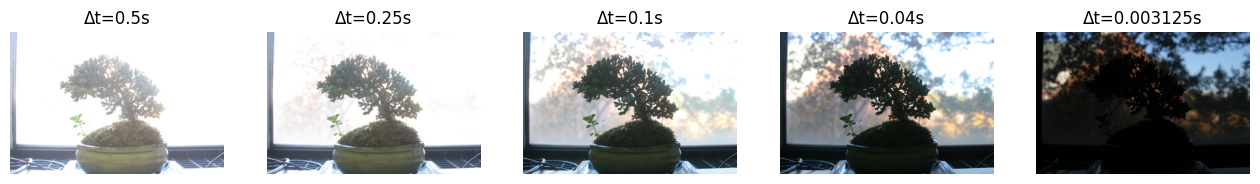

In [39]:
paths, exposures, num_exposures = parse_files('./data/bonsai')
fig, axes = plt.subplots(1, num_exposures, figsize=(16, 16))
for path, exposure, ax in zip(paths, exposures, axes):
    im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    ax.imshow(im)
    ax.set_title(f"Δt={exposure}s")
    ax.axis('off')
plt.show()

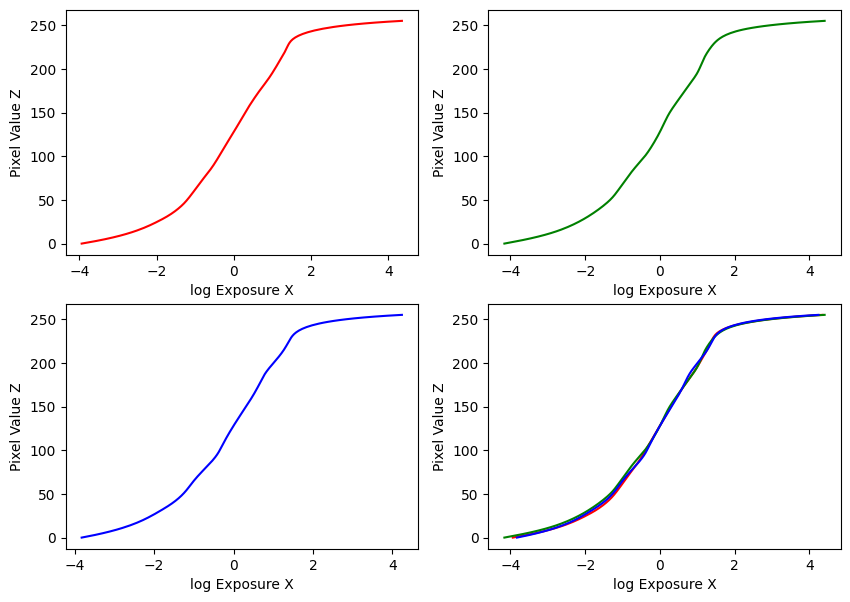

In [40]:
im = cv2.imread(paths[0])
h, w = im.shape[0], im.shape[1]
num_pixels = w * h
sample_matrix = create_sample_matrix(paths, num_pixels, num_exposures)
exposure_matrix = np.zeros((sample_matrix.shape[0] * sample_matrix.shape[1], num_exposures))
for i in range(num_exposures):
    exposure_matrix[:, i] = np.log(exposures[i])
l = 50.0
t = np.arange(1, 129)
weights = np.concatenate([t, t[::-1]], axis=0)

g_red, le_red = solve_g(sample_matrix[..., 0], exposure_matrix, l, weights)
g_green, le_green = solve_g(sample_matrix[..., 1], exposure_matrix, l, weights)
g_blue, le_blue = solve_g(sample_matrix[..., 2], exposure_matrix, l, weights)

plot_g(g_red, g_green, g_blue)

In [47]:
hdr_radiance_map = hdr(paths, g_red, g_green, g_blue, weights, exposure_matrix, num_exposures)

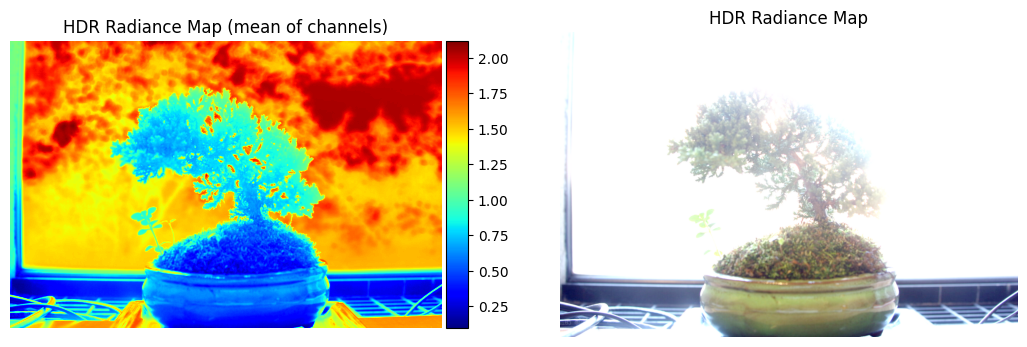

In [48]:
plt.figure(figsize=(13, 6))

rad_map = np.log(hdr_radiance_map+1)
mean_rad_map = rad_map.mean(axis=-1)

plt.subplot(1, 2, 1)
plt.title("HDR Radiance Map (mean of channels)")
plt.axis('off')
ax = plt.gca()
rad_map_im = ax.imshow(mean_rad_map, cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(rad_map_im, cax=cax)

rad_map = np.clip(rad_map, 0., 1.)

plt.subplot(1, 2, 2)
plt.imshow(rad_map)
plt.axis('off')
plt.title("HDR Radiance Map")

plt.show()

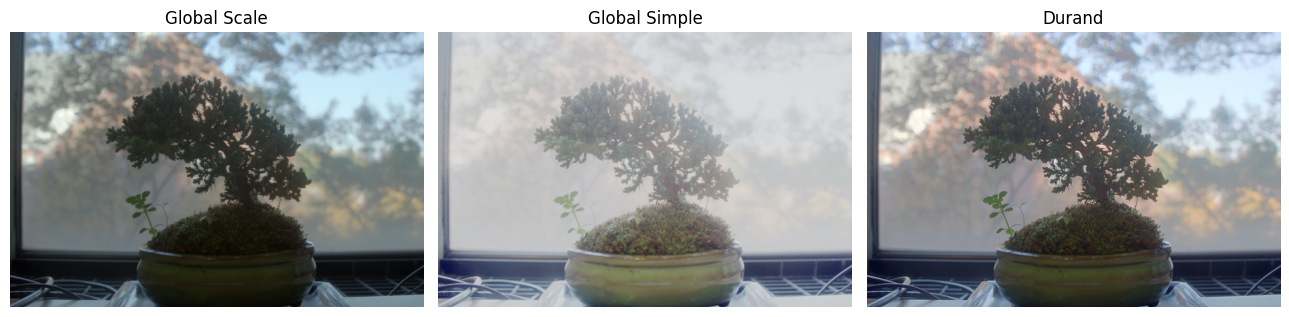

In [43]:
reload(utils)
reload(student)
from utils import parse_files, create_sample_matrix, plot_g, tm_global_scale
from student import solve_g, hdr, tm_global_simple, tm_durand

global_scale = tm_global_scale(hdr_radiance_map)
global_simple = tm_global_simple(hdr_radiance_map)
durand = tm_durand(hdr_radiance_map)

# Plot global scale tone mapping
plt.figure(figsize=(13, 6))
plt.subplot(1, 3, 1)
plt.imshow(global_scale)
plt.axis('off')
plt.title("Global Scale")

# Plot global simple tone mapping
plt.subplot(1, 3, 2)
plt.imshow(global_simple)
plt.axis('off')
plt.title("Global Simple")

# Plot Durand tone mapping
plt.subplot(1, 3, 3)
plt.imshow(durand)
plt.axis('off')
plt.title("Durand")

plt.tight_layout()
plt.show()

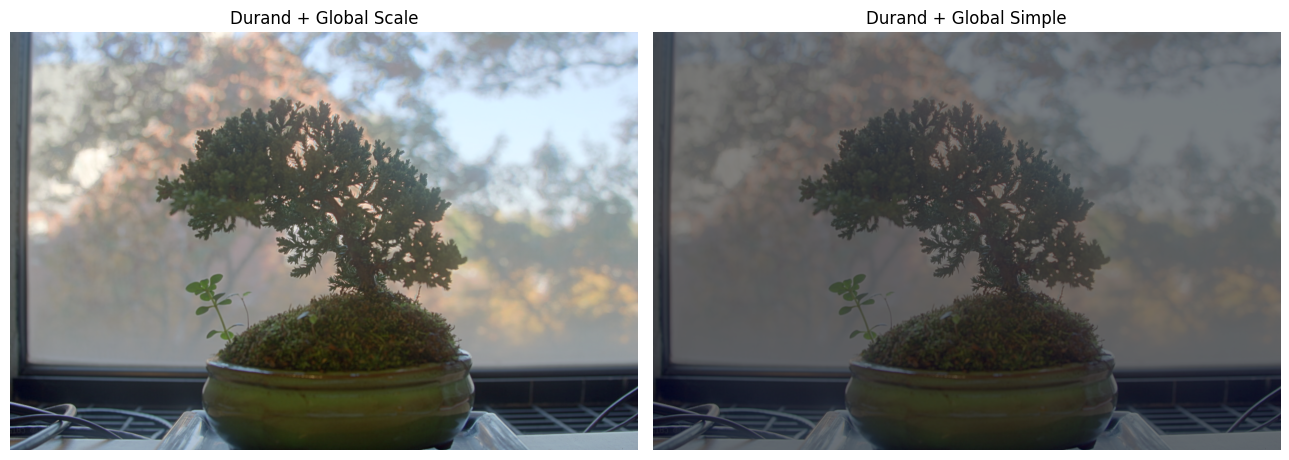

In [44]:
# Plot global scale tone mapping
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
plt.imshow(tm_global_scale(durand))
plt.axis('off')
plt.title("Durand + Global Scale")

plt.subplot(1, 2, 2)
plt.imshow(tm_global_simple(durand))
plt.axis('off')
plt.title("Durand + Global Simple")

plt.tight_layout()
plt.show()

In [31]:
def results(path, exp=False):
    paths, exposures, num_exposures = parse_files(path)
    im = cv2.imread(paths[0])
    h, w = im.shape[0], im.shape[1]
    num_pixels = w * h
    sample_matrix = create_sample_matrix(paths, num_pixels, num_exposures)
    exposure_matrix = np.zeros((sample_matrix.shape[0] * sample_matrix.shape[1], num_exposures))
    for i in range(num_exposures):
        exposure_matrix[:, i] = np.log(exposures[i])
    l = 50.0
    t = np.arange(1, 129)
    weights = np.concatenate([t, t[::-1]], axis=0)
    
    g_red, le_red = solve_g(sample_matrix[..., 0], exposure_matrix, l, weights)
    g_green, le_green = solve_g(sample_matrix[..., 1], exposure_matrix, l, weights)
    g_blue, le_blue = solve_g(sample_matrix[..., 2], exposure_matrix, l, weights)

    hdr_radiance_map = hdr(paths, g_red, g_green, g_blue, weights, exposure_matrix, num_exposures)
    # I found that for some datasets, it seemed that due to some construction, I didn't need to exponentiate here (?)
    if exp:
        hdr_radiance_map = np.exp(hdr_radiance_map)
        
    plt.figure(figsize=(13, 6))

    i = num_exposures // 2
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(paths[i]), cv2.COLOR_BGR2RGB))
    plt.title(f"{path}, Δt={exposures[i]}s")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(np.log(hdr_radiance_map+1).mean(axis=-1), cmap='jet')
    plt.title("Radiance Map")
    plt.axis('off')

    durand = tm_durand(hdr_radiance_map)
    plt.subplot(1, 4, 3)
    plt.imshow(durand)
    plt.axis('off')
    plt.title("Durand")

    plt.subplot(1, 4, 4)
    plt.imshow(tm_global_scale(durand))
    plt.axis('off')
    plt.title("Durand + Global Scale")


    plt.show()

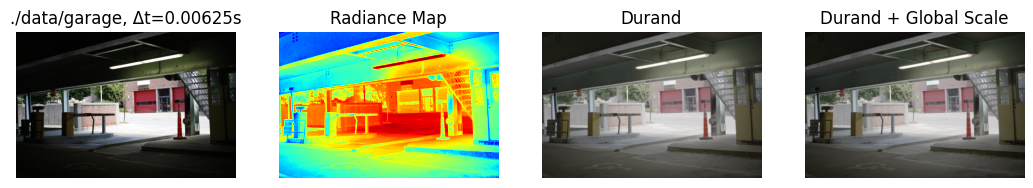

In [18]:
results('./data/garage')

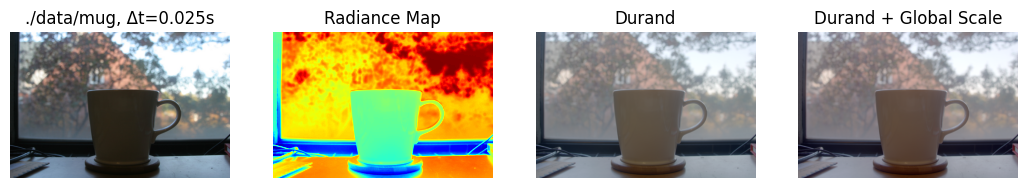

In [19]:
results('./data/mug')

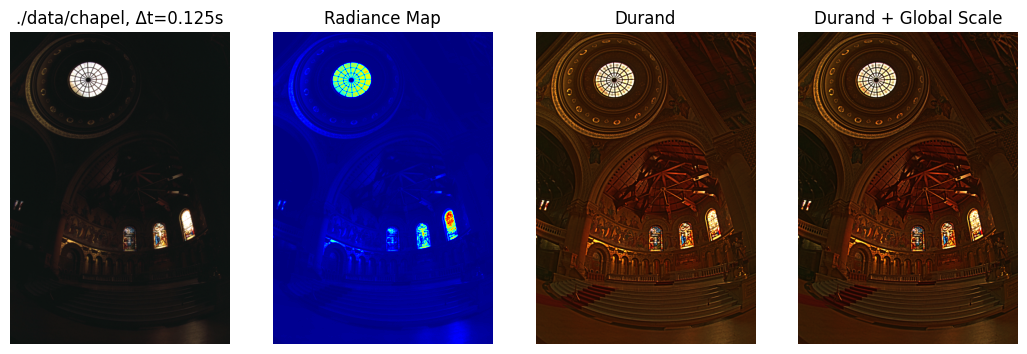

In [32]:
results('./data/chapel', exp=True)